# 03. Machine learning

This session will ...

Notes:

* Topic models
* Word vector embeddings -- examples of unsupervised techniques

* Examples of supervised ...

Some of the code in this notebook is based on work by Stéfan Sinclair and the [Trace of Theory](https://github.com/htrc/ACS-TT) project.

### Recreate the corpus

In [2]:
# Suppress compatibility warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import nltk
from nltk.corpus.reader.plaintext import PlaintextCorpusReader

text_dir = '../Data/Texts/'
corpus = PlaintextCorpusReader(text_dir, '.*\.txt')

# A function to turn fileids into a table of metadata
def parse_fileids(fileids):
    '''Takes a list of file names formatted like A-Cather-Antonia-1918-F.txt.
       Returns a pandas dataframe of derived metadata.'''
    import pandas as pd
    meta = {}
    for fileid in fileids:
        file = fileid.strip('.txt') # Get rid of file suffix
        fields = file.split('-') # Split on dashes
        fields[2] = fields[2].replace('_', ' ') # Remove underscore from titles
        fields[3] = int(fields[3])
        meta[file] = fields
    metadata = pd.DataFrame.from_dict(meta, orient='index') # Build dataframe
    metadata.columns = ['nation', 'author', 'title', 'pubdate', 'gender'] # Col names
    return metadata.sort_index() # Note we need to sort b/c datframe built from dictionary

def collect_stats(corpus):
    '''Takes an NLTK corpus as input. 
       Returns a pandas dataframe of stats indexed to fileid.'''
    import nltk
    import pandas as pd
    stats = {}
    for fileid in corpus.fileids():
        word_count = len(corpus.words(fileid))
        stats[fileid.strip('.txt')] = {'wordcount':word_count}
    statistics = pd.DataFrame.from_dict(stats, orient='index')
    return statistics.sort_index()

books = parse_fileids(corpus.fileids())
stats = collect_stats(corpus)
books = books.join(stats)
books.index.set_names('file', inplace=True)
books.head()

,nation,author,title,pubdate,gender,wordcount
file,,,,,,
A-Cather-Antonia-1918-F,A,Cather,Antonia,1918,F,97574
A-Chesnutt-Marrow-1901-M,A,Chesnutt,Marrow,1901,M,110288
A-Crane-Maggie-1893-M,A,Crane,Maggie,1893,M,28628
A-Davis-Life_Iron_mills-1861-F,A,Davis,Life Iron mills,1861,F,18789
A-Dreiser-Sister_Carrie-1900-M,A,Dreiser,Sister Carrie,1900,M,194062


## Unsupervised clustering

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import ward, dendrogram
%matplotlib inline

# Plot the documents from the corpus
def plot_corpus_similarity(corpus, vectorizer):
    '''Function to create two plots of corpus similarity.
       Takes an NLTK corpus and an SK-learn vectorizer as input.
       Creates a matplotlib plot with Ward dendrogram and 2D spatial plot.
       Returns nothing.'''
    
    # Generate vectors, distances and positions
    texts = [corpus.raw(fileid) for fileid in corpus.fileids()]
    documentTermMatrix = vectorizer.fit_transform(texts)
    distances = 1 - cosine_similarity(documentTermMatrix)
    mds = MDS(dissimilarity="precomputed", random_state=1)
    positions = mds.fit_transform(distances)
    
    # Plot dendrogram
    linkage_matrix = ward(distances)
    plt.figure(figsize=(8,10))
    dendrogram(linkage_matrix, labels=corpus.fileids(), orientation="right");
    plt.show()
    
    # Plot scatter
    xvalues = positions[:, 0] 
    yvalues = positions[: ,1] 
    plt.figure(figsize=(20,10))
    for x, y, name in zip(xvalues, yvalues, corpus.fileids()):
        plt.scatter(x, y)
        plt.text(x, y, name.replace(".txt", "")[:25], 
                 color='red' if 'A-' in name else 'blue')
    plt.show()

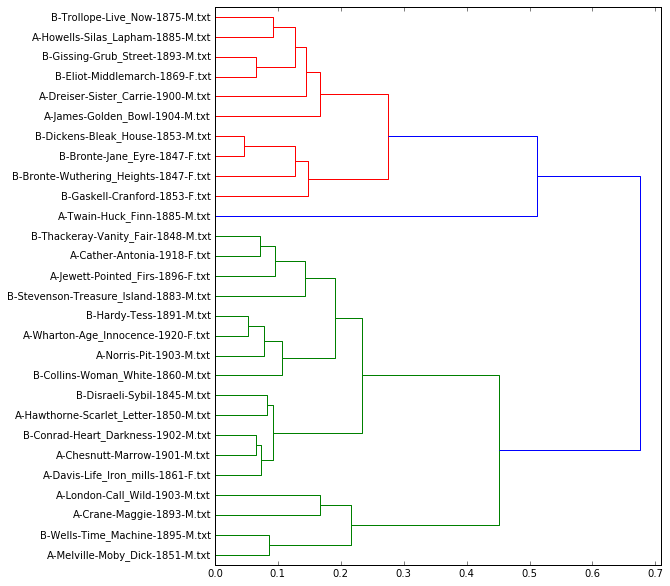

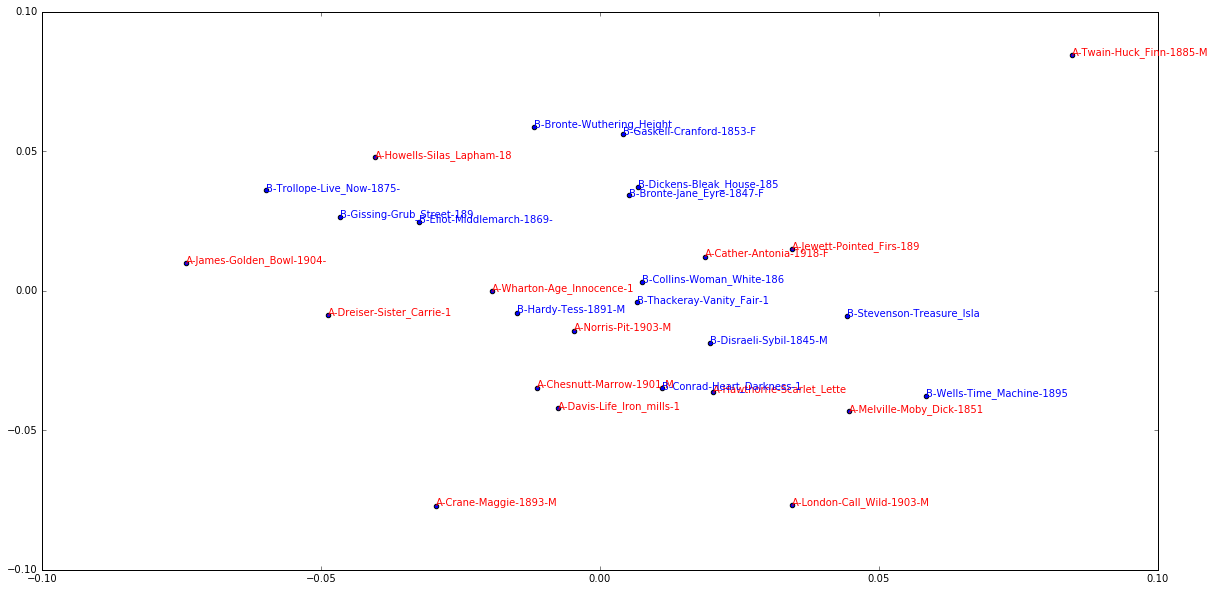

In [5]:
simple_vectorizer = TfidfVectorizer(use_idf=False)
plot_corpus_similarity(corpus, simple_vectorizer)

Now try the same plot, but with stopwords removed. Stopwords are common words that are not generally meaningful on their own ("the," "in," "a," etc.). Removing them allows us to compare the semantic content of the books more directly.

If the code below complains about missing the NLTK stopword list, run this line of code **from the command line** to download it:

>```python -m nltk.downloader stopwords```

In [6]:
stopwords = nltk.corpus.stopwords.words("english")
stopwords_better = [word.strip() for word in open('../Data/stopwords-underwood-goldstone.txt')]
stopwords_better[100:105]

['however', 'has', 'up', 'did', 'within']

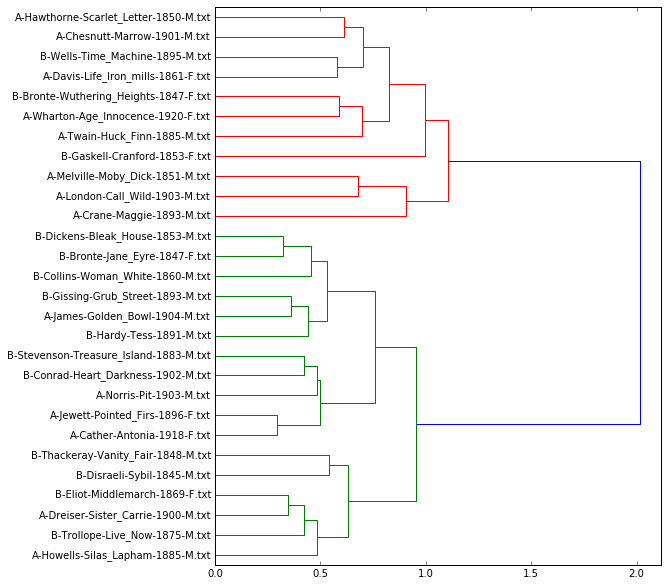

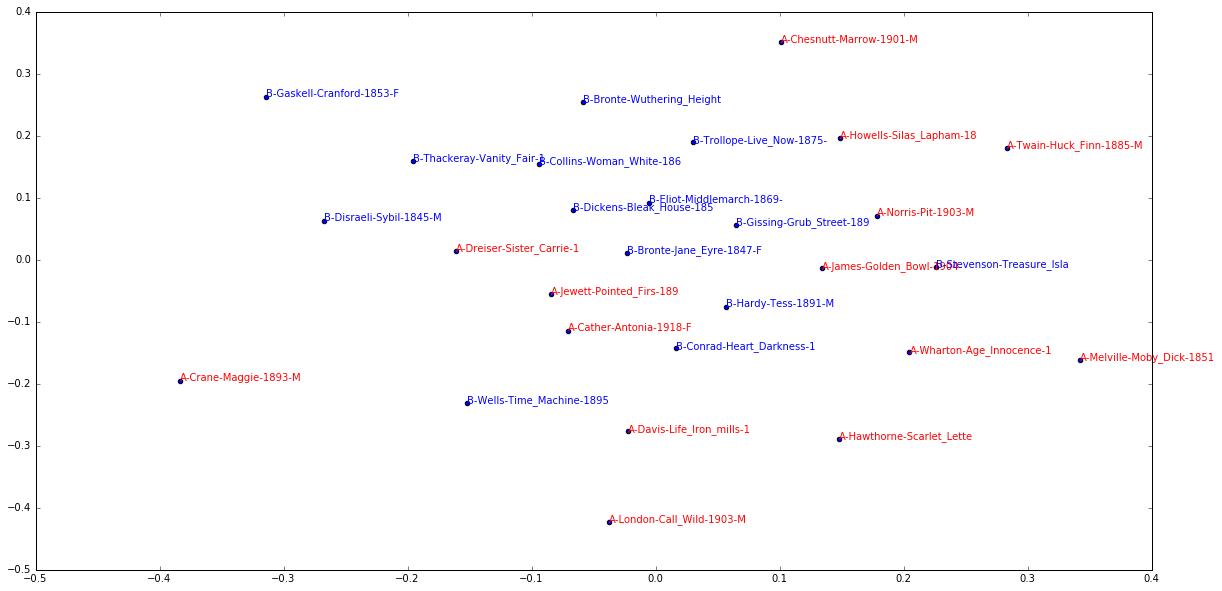

In [7]:
stoplist_vectorizer = TfidfVectorizer(use_idf=False, 
                                      stop_words=stopwords_better,
                                      max_features=5000)
plot_corpus_similarity(corpus, stoplist_vectorizer)

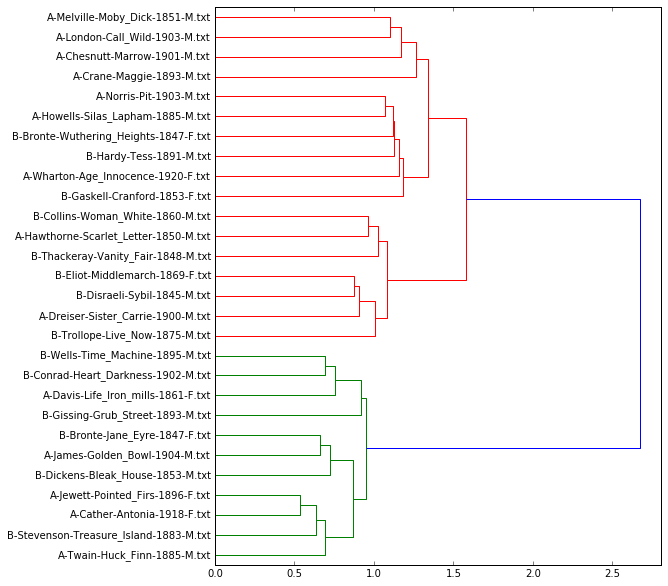

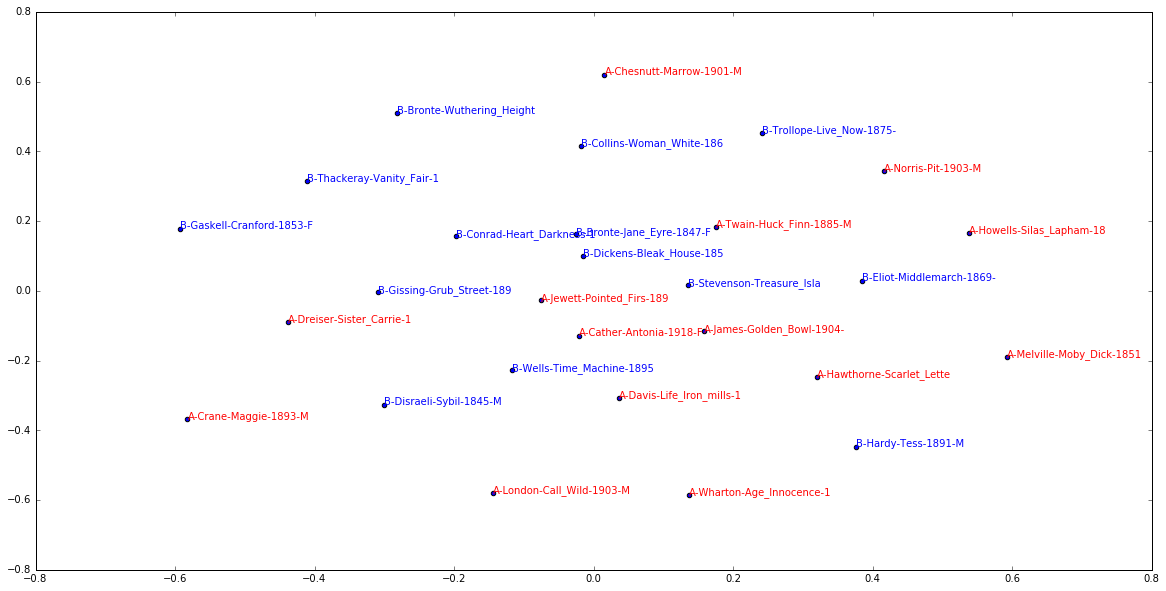

In [8]:
# Use TF-IDF
tfidf_vectorizer = TfidfVectorizer(use_idf=True, 
                                      stop_words=stopwords_better,
                                      max_features=5000)
plot_corpus_similarity(corpus, tfidf_vectorizer)

## Supervised classification

In [9]:
import random
from pandas import DataFrame
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid

In [10]:
def benchmark_svms(labelled_texts, runs, vectorizer, categories):
    '''Compare classifiers by averaging accuracy over multiple 50/50 splits of corpus.
       Takes a list of (label, raw_text) tuples, number of runs, NLTK vectorizer, and
          list of (indicator, category name) tuples.
       Prints accuracies and plots same.
       Returns results dataframe.'''
    results = defaultdict(list)
    split = int(len(labelled_texts)/2)
    for i in range(0, runs):
        random.shuffle(labelled_texts)
        train_set, test_set = labelled_texts[split:], labelled_texts[:split]
        train_set_categories = [categories[0][1] if categories[0][0] in category else categories[1][1] for category, text in train_set]
        test_set_categories  = [categories[0][1] if categories[0][0] in category else categories[1][1] for category, text in test_set]
        X_train = vectorizer.fit_transform([text for category, text in train_set])
        X_test = vectorizer.transform([text for category, text in test_set])

        for clf, name in (
                (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
                (Perceptron(n_iter=50), "Perceptron"),
                (PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
                (KNeighborsClassifier(n_neighbors=10), "kNN"),
                (LinearSVC(), "LinearSVC"),
                (LinearSVC(loss='squared_hinge', penalty="l2", dual=False, tol=1e-3), "LinearSCV L2"),
                (LinearSVC(loss='squared_hinge', penalty="l1", dual=False, tol=1e-3), "LinearSCV L1"),
                (SGDClassifier(alpha=.0001, n_iter=50, penalty="l2"), "SGD L2"),
                (SGDClassifier(alpha=.0001, n_iter=50, penalty="l1"), "SGD L1"),
                (SGDClassifier(alpha=.0001, n_iter=50, penalty="elasticnet"), "SGD elasticnet"),
                (NearestCentroid(), "NearestCentroid"),
                (MultinomialNB(alpha=.01), "Naïve Bayes Multinomial"),
                (BernoulliNB(alpha=.01), "Naïve Bayes Bernoulli")):
            clf.fit(X_train, train_set_categories)
            pred = clf.predict(X_test)
            results[name].append(clf.score(X_test, test_set_categories))
    orderedresults = [(name, values) for name, values in results.items()] 
    results_df = DataFrame([values for name,values in orderedresults], 
                           index=[name for name,values in orderedresults])
    summary = DataFrame(results_df.mean(axis=1), columns=['acc'])
    summary['std'] = results_df.std(axis=1)
    print("Ordered averages:")
    print(summary.sort_values('acc', ascending=False))
    results_df.transpose().plot(figsize=(20, 10))
    return results_df

Ordered averages:
                              acc       std
Naïve Bayes Bernoulli    0.707143  0.085516
NearestCentroid          0.664286  0.101295
Passive-Aggressive       0.642857  0.095238
SGD L1                   0.642857  0.075292
Naïve Bayes Multinomial  0.628571  0.105409
SGD L2                   0.621429  0.101295
LinearSCV L2             0.614286  0.096421
LinearSVC                0.614286  0.096421
Ridge Classifier         0.600000  0.131277
SGD elasticnet           0.585714  0.081092
Perceptron               0.571429  0.130410
LinearSCV L1             0.514286  0.120468
kNN                      0.464286  0.069416
CPU times: user 57.1 s, sys: 1.28 s, total: 58.4 s
Wall time: 54.5 s


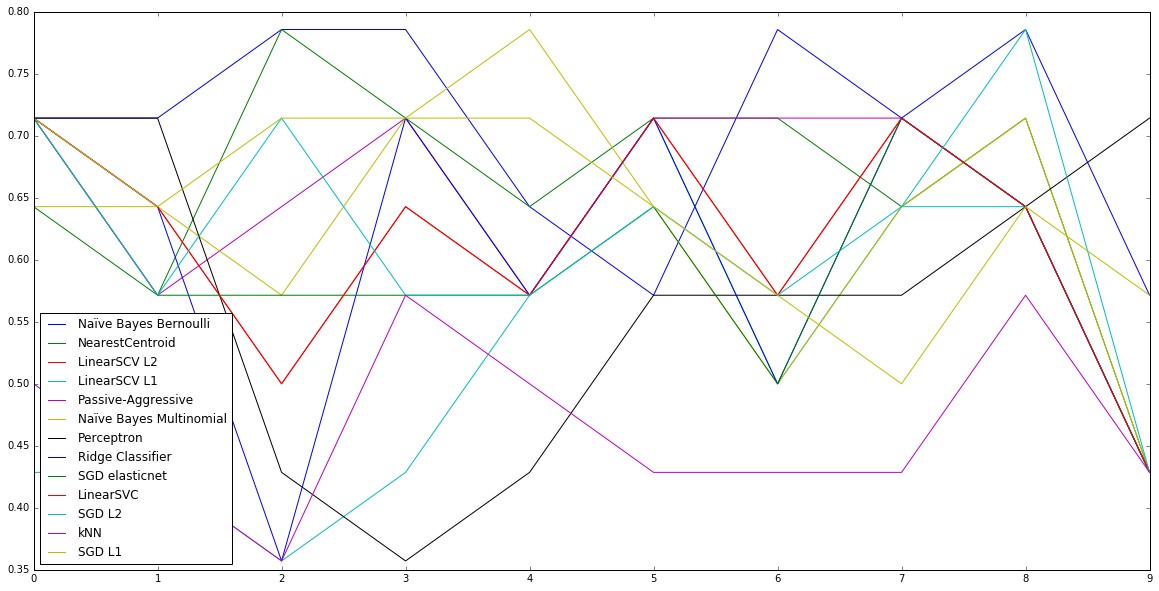

In [12]:
labelled_texts = [(fileid, corpus.raw(fileid)) for fileid in corpus.fileids()]
nation_labels = [('A-', 'American'), ('B-', 'British')]
%time results = benchmark_svms(labelled_texts, 10, stoplist_vectorizer, nation_labels)

### Try classifying author gender

Ordered averages:
                              acc       std
LinearSCV L1             0.728571  0.065638
Naïve Bayes Multinomial  0.721429  0.052705
Ridge Classifier         0.721429  0.052705
LinearSCV L2             0.714286  0.047619
LinearSVC                0.714286  0.047619
Perceptron               0.714286  0.095238
kNN                      0.700000  0.065638
Passive-Aggressive       0.692857  0.082822
NearestCentroid          0.685714  0.107539
Naïve Bayes Bernoulli    0.685714  0.060234
SGD elasticnet           0.635714  0.144632
SGD L2                   0.614286  0.135526
SGD L1                   0.614286  0.112687
CPU times: user 54.7 s, sys: 1.35 s, total: 56 s
Wall time: 51.9 s


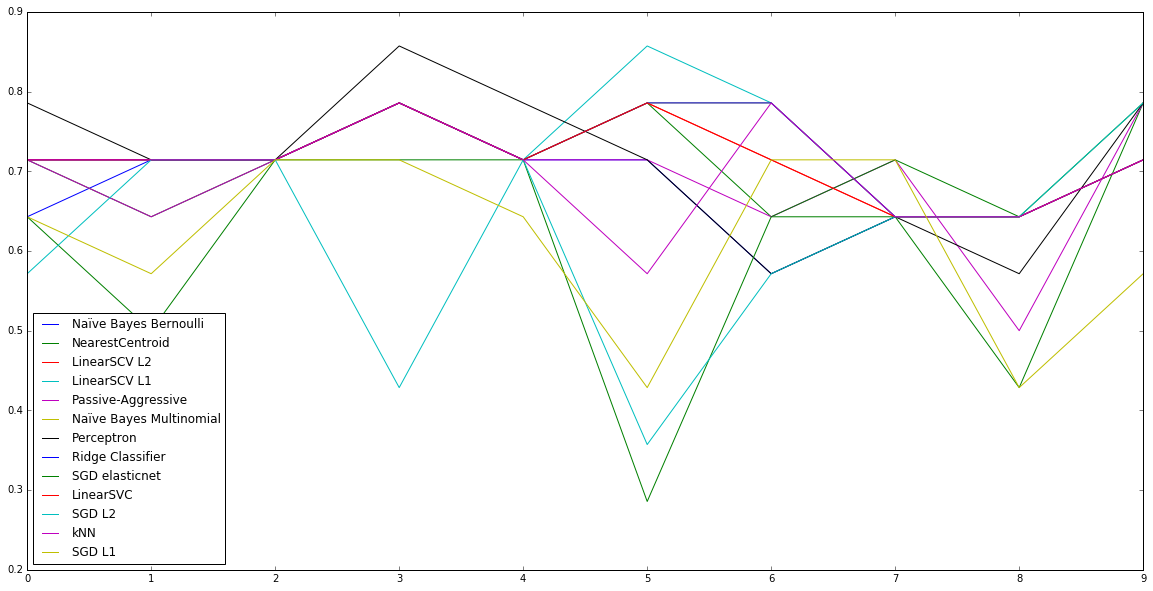

In [13]:
gender_labels = [('-F', 'Female'), ('-M', 'Male')]
%time results = benchmark_svms(labelled_texts, 10, stoplist_vectorizer, gender_labels)